## __準備__

In [ ]:
!pip install optuna
!pip install catboost
#!pip install sweetviz
#!pip install wandb

# import sweetviz as sv

import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import optuna

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression

# import wandb
# wandb.login()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR_NAME = '/content/drive/MyDrive/DataCompetition/SMBC/data/'

# データの読み込み
train = pd.read_csv(DIR_NAME + 'train.csv', index_col=0)
test = pd.read_csv(DIR_NAME + 'test.csv', index_col=0)
submit_sample = pd.read_csv(DIR_NAME + 'sample_submission.csv', index_col=0, header=None, names=['id', 'y'])

## __前処理__

In [ ]:
over50 = ['Kentucky coffeetree', 'honeylocust', 'ginkgo', 'American beech', 'European beech', 'hardy rubber tree', 'Turkish hazelnut', 'katsura tree', 'common hackberry', 'river birch', 'Ohio buckeye', 'horse chestnut', 'red maple', 'London planetree', 'dawn redwood', 'sweetgum', 'shingle oak', 'white oak', 'swamp white oak', 'pin oak', 'bur oak', 'black oak', 'pin oak', 'scarlet oak', 'willow oak', 'English oak', "Schumard's oak", 'northern red oak', 'black oak', 'bald cypress', 'littleleaf linden', 'silver linden', 'American linden', 'American elm', 'Japanese zelkova']
over35_under50 = ['red horse chestnut', 'American hophornbeam', 'European hornbeam', 'Japanese hornbeam', 'Kentucky yellowwood', 'golden raintree', 'Amur maackia', 'Persian ironwood', 'hedge maple', ]
under35 = ['Amur maple', 'paperbark maple', 'eastern redbud', 'Oklahoma redbud', 'serviceberry', 'Chinese fringetree', 'flowering dogwood', 'kousa dogwood', 'pagoda dogwood', 'crab apple', 'cockspur hawthorn', 'hawthorn', 'Japanese tree lilac', 'Chinese tree lilac']

teardrop = ['Japanese zelkova', 'Callery pear', 'mulberry', 'silver birch', 'pagoda dogwood', 'Cornelian cherry', 'catalpa', 'American beech', 'quaking aspen', 'bigtooth aspen', 'cucumber magnolia', 'magnolia', 'southern magnolia']
spade = ["'Schubert' chokecherry", 'eastern redbud', 'Oklahoma redbud', 'katsura tree', 'paper birch', 'empress tree', 'eastern cottonwood']
uneven = ['littleleaf linden', 'silver linden', 'American linden', 'American elm', 'Chinese elm', 'Siberian elm', 'Japanese tree lilac', 'Chinese tree lilac']
oak = ['English oak', "Schumard's oak",'pin oak', 'bur oak', 'black oak', 'scarlet oak', 'swamp white oak', 'northern red oak', 'white oak', 'shingle oak']
broom = ['pitch pine', 'red pine', 'white pine', 'pine']
feather = ['dawn redwood', 'bald cypress', 'Norway spruce', 'blue spruce', 'spruce', 'eastern hemlock']
compoundhand = ['red horse chestnut', 'horse chestnut', 'Ohio buckeye', 'paperbark maple']
compoundline = ['honeylocust', 'green ash', 'ash', 'white ash', 'Sophora', 'Kentucky coffeetree', 'golden raintree', 'Amur maackia', 'tree of heaven', 'black locust', 'Kentucky yellowwood', 'black walnut', 'Amur cork tree', 'Amur maackia', 'pignut hickory']
scales = ['eastern redcedar', 'arborvitae', 'Atlantic white cedar', 'Himalayan cedar', 'Atlas cedar', 'bald cypress', 'pond cypress', 'false cypress']
football = ['cherry', 'black cherry', 'purple-leaf plum', 'American hornbeam', 'American hophornbeam', 'European hornbeam', 'Japanese hornbeam', 'crab apple', 'serviceberry', 'flowering dogwood', 'kousa dogwood', 'cucumber magnolia', 'magnolia', 'southern magnolia', 'sawtooth oak', 'willow oak', 'shingle oak', 'hardy rubber tree', 'Japanese snowbell', 'blackgum', 'Persian ironwood', 'crepe myrtle', 'Chinese fringetree', 'European beech', 'two-winged silverbell', 'holly', 'hawthorn', 'cockspur hawthorn']
hand = ['London planetree', 'crimson king maple', 'Amur maple', 'Norway maple', 'silver maple', 'maple', 'red maple', 'tartar maple', 'sycamore maple', 'hedge maple', 'Japanese maple', 'sugar maple', 'Shantung maple','paperbark maple', 'trident maple', 'tulip-poplar', 'sweetgum', 'hawthorn', 'cockspur hawthorn', 'ginkgo', 'Turkish hazelnut', 'sassafras']

spc_list = {'over50':over50, 'over35_under50':over35_under50, 'under35':under35, 'teardrop':teardrop, 'spade':spade, 'uneven':uneven, 'oak':oak, 'broom':broom, 'feather':feather, 'compoundhand':compoundhand, 'compoundline':compoundline, 'scales':scales, 'football':football, 'hand':hand}

def get_data(data):
    data = data.drop(['spc_latin', 'nta', 'nta_name', 'boroname', 'borocode', 'cb_num', 'st_senate', 'zip_city'], axis=1) #

    data['created_at'] = data['created_at'].apply(lambda x: x[5:7])
    data['created_at_int'] = data['created_at'].apply(lambda x: int(x))
    data['seasons'] = data['created_at'].apply(lambda x: 1 if int(x) in [3, 4, 5] else (2 if int(x) in [6, 7, 8] else (3 if int(x) in [9, 10, 11] else (4 if int(x) in [12, 1, 2] else None))))

    spc_dbh = data.groupby('spc_common')['tree_dbh'].mean()
    data['spc_dbh'] = data['spc_common'].map(spc_dbh)
    data['dbh_diff'] = data['spc_dbh'] - data['tree_dbh']


    spc_dbh_max = data.groupby('spc_common')['tree_dbh'].max()
    spc_dbh_min = data.groupby('spc_common')['tree_dbh'].min()
    spc_dbh_max = data['spc_common'].map(spc_dbh_max)
    spc_dbh_min = data['spc_common'].map(spc_dbh_min)
    data['spc_dbh_wide'] = spc_dbh_max - spc_dbh_min

    for k, v in spc_list.items():
        data[f'{k}'] = data['spc_common'].isin(v).astype(int)

    data.fillna('other', inplace=True)

    data['problems'] = data['problems'].apply(lambda x: 0 if x=='other' else 1)

    return data


def get_dataset(train, test):
    train_data = get_data(train)
    test_data = get_data(test)

    train_x = train_data.drop(['health'], axis=1)
    y = train_data['health']

    all_x = pd.concat([train_x, test_data])
    all_x = pd.get_dummies(all_x)

    X = all_x.iloc[:train_x.shape[0],:].reset_index(drop=True)
    X_test = all_x.iloc[train_x.shape[0]:,:].reset_index(drop=True)

    class_weights = {1:1, 0:3.901, 2:16}
    X['weight'] = y.apply(lambda x: class_weights[x])

    return X, y, X_test

X, y, X_test = get_dataset(train, test)

## __学習__





In [ ]:
# パラメータ設定
SEED = 42 # シード値
FOLDS = 5 # 分割数 K
NUM_BOOST_ROUND = 1000 # イテレーションの回数

valid_scores, results, models, oof_preds_lgb1 = [], [], [], np.zeros((X.shape[0], 3))

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting': 'gbdt',
    'metric': 'multi_logloss', # 評価指標
    'seed': 8,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'early_stopping_round': 10,
    'max_depth': 5,
    'num_leaves': 20
}

kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_indices].copy(), X.iloc[valid_indices].copy()
    y_train, y_valid = y[train_indices], y[valid_indices]

    lgb_train = lgb.Dataset(
        X_train.drop("weight", axis=1),
        y_train,
        weight=X_train["weight"]
    )
    lgb_valid = lgb.Dataset(
        X_valid.drop("weight", axis=1),
        y_valid,
        reference=lgb_train,
        weight=X_valid["weight"]
    )

    result = {}
    model_lgbm1 = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['Train', 'Valid'],
        num_boost_round=NUM_BOOST_ROUND,
        callbacks=[
            lgb.callback.record_evaluation(result),
        ],
    )

    # 検証データのスコア
    y_valid_pred = model_lgbm1.predict(X_valid.drop("weight", axis=1), num_iteration=model_lgbm1.best_iteration)
    oof_preds_lgb1[valid_indices] = y_valid_pred  # out-of-fold予測を保存

    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    score = f1_score(y_valid, y_valid_pred_class, average='macro')
    valid_scores.append(score)
    print(f'Fold: {fold+1}  macrof1: {score}')

    report = classification_report(y_valid, y_valid_pred_class)
    print(report)

    results.append(result)

# cv_score = np.mean(valid_scores)
# print(f'CV: {cv_score}')

Fold: 1  macrof1: 0.3758619074537095
              precision    recall  f1-score   support

           0       0.24      0.24      0.24       707
           1       0.80      0.80      0.80      3151
           2       0.08      0.09      0.09       139

    accuracy                           0.68      3997
   macro avg       0.37      0.38      0.38      3997
weighted avg       0.68      0.68      0.68      3997

Fold: 2  macrof1: 0.3597918655145013
              precision    recall  f1-score   support

           0       0.22      0.23      0.23       707
           1       0.80      0.79      0.80      3150
           2       0.05      0.06      0.06       140

    accuracy                           0.66      3997
   macro avg       0.36      0.36      0.36      3997
weighted avg       0.67      0.66      0.67      3997

Fold: 3  macrof1: 0.3707919268543305
              precision    recall  f1-score   support

           0       0.24      0.23      0.23       707
           1      

In [ ]:
valid_scores, results, models, oof_preds_lgb2 = [], [], [], np.zeros((X.shape[0], 3))

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting': 'gbdt',
    'metric': 'multi_logloss',
    'seed': 8,
    'learning_rate': 0.05,
    'bagging_freq': 1,
    'verbose': -1,
    'early_stopping_round': 10,
    'max_depth': 4,
    'num_leaves': 16,
    'feature_fraction': 0.6795216675566491,
    'bagging_fraction': 0.648097155291466
}

kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_indices].copy(), X.iloc[valid_indices].copy()
    y_train, y_valid = y[train_indices], y[valid_indices]

    lgb_train = lgb.Dataset(
        X_train.drop("weight", axis=1),
        y_train,
        weight=X_train["weight"]
    )
    lgb_valid = lgb.Dataset(
        X_valid.drop("weight", axis=1),
        y_valid,
        reference=lgb_train,
        weight=X_valid["weight"]
    )

    result = {}
    model_lgbm2 = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['Train', 'Valid'],
        num_boost_round=NUM_BOOST_ROUND,
        callbacks=[
            lgb.callback.record_evaluation(result),
        ],
    )

    # 検証データのスコア
    y_valid_pred = model_lgbm2.predict(X_valid.drop("weight", axis=1), num_iteration=model_lgbm2.best_iteration)
    oof_preds_lgb2[valid_indices] = y_valid_pred

    y_valid_pred_class = np.argmax(y_valid_pred, axis=1)
    score = f1_score(y_valid, y_valid_pred_class, average='macro')
    valid_scores.append(score)
    print(f'Fold: {fold+1}  macrof1: {score}')

    report = classification_report(y_valid, y_valid_pred_class)
    print(report)

    results.append(result)

# cv_score = np.mean(valid_scores)
# print(f'CV: {cv_score}')

Fold: 1  macrof1: 0.38327035129437426
              precision    recall  f1-score   support

           0       0.24      0.25      0.25       707
           1       0.81      0.77      0.79      3151
           2       0.09      0.16      0.12       139

    accuracy                           0.66      3997
   macro avg       0.38      0.39      0.38      3997
weighted avg       0.68      0.66      0.67      3997

Fold: 2  macrof1: 0.3622365648271255
              precision    recall  f1-score   support

           0       0.21      0.26      0.23       707
           1       0.81      0.74      0.77      3150
           2       0.06      0.12      0.08       140

    accuracy                           0.63      3997
   macro avg       0.36      0.37      0.36      3997
weighted avg       0.68      0.63      0.65      3997

Fold: 3  macrof1: 0.3827998805737384
              precision    recall  f1-score   support

           0       0.25      0.24      0.25       707
           1     

In [ ]:
def get_dataset(train, test):
    train_data = get_data(train)
    test_data = get_data(test)

    train_x = train_data.drop(['health'], axis=1)
    y = train_data['health']

    X = train_x
    X_test = test_data

    return X, y, X_test

X_cat, y, X_test_cat = get_dataset(train, test)

from scipy.misc import derivative

categorical_features_indices = np.where(X_cat.dtypes==np.object)[0]

SEED = 42 # シード値
FOLDS = 4 # 分割数 K
STOPPING_ROUNDS = 10 # アーリーストッピングのパラメータ
NUM_BOOST_ROUND = 1000 # イテレーションの回数

valid_scores, results, models, oof_preds_cat = [], [], [], np.zeros((X.shape[0], 1))


kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X_cat, y)):
    X_train, X_valid = X_cat.iloc[train_indices].copy(), X_cat.iloc[valid_indices].copy()
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    y_test_preds = pd.DataFrame()

    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features_indices)

    model_cat = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=5,
        # l2_leaf_reg=1,
        class_weights=[3.9,1,16],
        loss_function='MultiClass',
        verbose=100
    )

    # モデルのトレーニング
    model_cat.fit(train_pool,
                eval_set=valid_pool,
                early_stopping_rounds=10,
                use_best_model=True)

    # テストデータで予測
    y_valid_pred = model_cat.predict(X_valid)
    oof_preds_cat[valid_indices] = y_valid_pred
    score = f1_score(y_valid, y_valid_pred, average='macro')
    # wandb.log({"macro-f1": score})
    valid_scores.append(score)
    print(f'Fold: {fold+1}  macrof1: {score}')

    report = classification_report(y_valid, y_valid_pred)
    print(report)

cv_score = np.mean(valid_scores)
print(f'CV: {np.mean(cv_score)}')

# wandb.finish()

<ipython-input-7-cda39b3c04f2>:17: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_cat.dtypes==np.object)[0]


0:	learn: 1.0968108	test: 1.0970968	best: 1.0970968 (0)	total: 120ms	remaining: 1m 59s
100:	learn: 1.0447767	test: 1.0711323	best: 1.0711032 (99)	total: 4.68s	remaining: 41.6s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.070526123
bestIteration = 119

Shrink model to first 120 iterations.
Fold: 1  macrof1: 0.3710155672891546
              precision    recall  f1-score   support

           0       0.22      0.25      0.23       883
           1       0.80      0.78      0.79      3938
           2       0.09      0.09      0.09       175

    accuracy                           0.66      4996
   macro avg       0.37      0.37      0.37      4996
weighted avg       0.68      0.66      0.67      4996

0:	learn: 1.0963657	test: 1.0973606	best: 1.0973606 (0)	total: 66.6ms	remaining: 1m 6s
100:	learn: 1.0429678	test: 1.0790946	best: 1.0787361 (93)	total: 6.66s	remaining: 59.2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 1.078736139
bestIteration =

In [ ]:
X, y, X_test = get_dataset(train, test)
class_weights = {1:1, 0:3.8, 2:14.5}
X['weight'] = y.apply(lambda x: class_weights[x])

# スタッキング用特徴セット
stacked_features = np.column_stack((oof_preds_lgb1, oof_preds_lgb2, oof_preds_cat))

# StratifiedKFoldとパラメータ設定
folds = 5
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
meta_scores = []

meta_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 10,
    'early_stopping_round':10,
    'verbose': -1
}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = stacked_features[train_index], stacked_features[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_weight = X.iloc[train_index]['weight']
    test_weight = X.iloc[test_index]['weight']

    # LightGBMデータセットの作成、重みを指定
    lgb_train = lgb.Dataset(X_train, label=y_train, weight=train_weight)
    lgb_valid = lgb.Dataset(X_test, label=y_test, weight=test_weight)

    # モデルのトレーニング
    model = lgb.train(
        params=meta_params,
        train_set=lgb_train,
        valid_sets=lgb_valid,
        num_boost_round=100
    )

    # 性能評価
    predictions = model.predict(X_test, num_iteration=model.best_iteration)
    predictions_classes = np.argmax(predictions, axis=1)
    score = f1_score(y_test, predictions_classes, average='macro', sample_weight=test_weight)
    meta_scores.append(score)

    print(classification_report(y_test, predictions_classes))
    score = f1_score(y_test, predictions_classes, average='macro')
    print(f'macrof1: {score}')

# 平均スコアの計算と報告
average_score = np.mean(meta_scores)
print(f'Average macro F1 score across all folds: {average_score}')


              precision    recall  f1-score   support

           0       0.24      0.27      0.25       707
           1       0.81      0.75      0.78      3151
           2       0.05      0.11      0.07       139

    accuracy                           0.64      3997
   macro avg       0.37      0.37      0.37      3997
weighted avg       0.68      0.64      0.66      3997

macrof1: 0.36578572075882093
              precision    recall  f1-score   support

           0       0.22      0.16      0.18       707
           1       0.80      0.86      0.83      3150
           2       0.02      0.01      0.02       140

    accuracy                           0.71      3997
   macro avg       0.35      0.34      0.34      3997
weighted avg       0.67      0.71      0.69      3997

macrof1: 0.34233515452455654
              precision    recall  f1-score   support

           0       0.24      0.26      0.25       707
           1       0.81      0.75      0.78      3150
           2     

In [ ]:
stacked_features = np.column_stack((oof_preds_lgb1, oof_preds_lgb2, oof_preds_cat))

class_weights = {1:1, 0:3.901, 2:14}
X['weight'] = y.apply(lambda x: class_weights[x])

meta_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 20
}

meta_lgb_train = lgb.Dataset(stacked_features,
                             label=y,
                             weight=X["weight"])
meta_model = lgb.train(
    params=meta_params,
    train_set=meta_lgb_train,
    num_boost_round=20
)

# メタモデルの性能評価
meta_predictions = meta_model.predict(stacked_features, num_iteration=meta_model.best_iteration)
meta_predictions_classes = np.argmax(meta_predictions, axis=1)
report = classification_report(y, meta_predictions_classes)
print(report)
score = f1_score(y, meta_predictions_classes, average='macro')
print(f'macrof1: {score}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 19984, number of used features: 7
[LightGBM] [Info] Start training from score -1.047610
[LightGBM] [Info] Start training from score -0.914652
[LightGBM] [Info] Start training from score -1.392035
              precision    recall  f1-score   support

           0       0.26      0.29      0.27      3535
           1       0.81      0.80      0.81     15751
           2       0.16      0.14      0.15       698

    accuracy                           0.68     19984
   macro avg       0.41      0.41      0.41     19984
weighted avg       0.69      0.68      0.69     19984

macrof1: 0.40971011880997055


## __予測__

In [ ]:
# 仮想的なテストデータセット
# X_test をテストデータとして仮定

# 1層目のモデルでテストデータに対する予測を行う
preds_lgbm1 = model_lgbm1.predict(X_test)
preds_lgbm2 = model_lgbm2.predict(X_test)
preds_cat = model_cat.predict(X_test_cat)
#preds_catboost = model_catboost.predict_proba(X_test)

# スタッキング用の特徴セットを作成
test_stacked_features = np.column_stack((preds_lgbm1, preds_lgbm2, preds_cat)) #, preds_catboost))

# 2層目のメタモデルで最終的な予測を行う
final_predictions = meta_model.predict(test_stacked_features)
series = pd.Series(final_predictions)
series.value_counts()

1    15225
0     3830
2      647
dtype: int64

In [ ]:
def predicting(models, X_test):
    y_test_preds = pd.DataFrame()
    y_test_preds['id'] = test.index
    preds_lgbm1 = model_lgbm1.predict(X_test)
    preds_lgbm2 = model_lgbm2.predict(X_test)
    preds_cat = model_cat.predict(X_test_cat)
    test_stacked_features = np.column_stack((preds_lgbm1, preds_lgbm2, preds_cat)) #, preds_catboost))
    y_test_preds['pred'] = meta_model.predict(test_stacked_features)

    return y_test_preds

df = predicting(models, X_test)
df[['id', 'pred']].to_csv(DIR_NAME + f'../output/stacking_cat_cv{score.round(5)}.csv', header=None, index=None)
print(score.round(5))

0.37303


1    15751
0     3535
2      698
Name: health, dtype: int64 1    15225
0     3830
2      647
Name: pred, dtype: int64


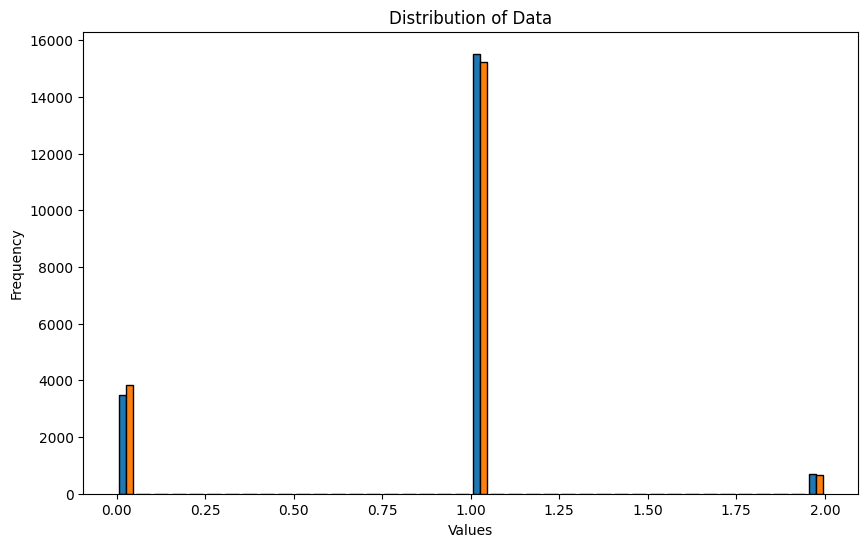

In [ ]:
df['train'] = y
print(y.value_counts(), df['pred'].value_counts())

plt.figure(figsize=(10, 6))
plt.hist(df[['train', 'pred']], bins=40, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.show()

## __探索__

In [ ]:
NUM_BOOST_ROUND = 1000 # イテレーションの回数

def fit_lgbm(X, y, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_indices, valid_indices) in enumerate(kf.split(X, y)):
        X_train, X_valid = X.iloc[train_indices].copy(), X.iloc[valid_indices].copy()
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        lgb_train = lgb.Dataset(
            X_train.drop("weight", axis=1),
            y_train,
            weight=X_train["weight"]
        )

        lgb_valid = lgb.Dataset(
            X_valid.drop("weight", axis=1),
            y_valid,
            reference=lgb_train,
            weight=X_valid["weight"]
        )

        result = {}
        model = lgb.train(
            params=params,
            train_set=lgb_train, # 学習データ
            valid_sets=[lgb_train, lgb_valid], # 検証データ
            valid_names=['Train', 'Valid'], # 学習経過で表示する名称
            num_boost_round=NUM_BOOST_ROUND, # イテレーションの回数
            #verbose_eval=False,# 出力を抑える
            callbacks=[
                lgb.early_stopping(stopping_rounds=10, verbose=False), # アーリーストッピング
                lgb.callback.record_evaluation(result), # ログの記録
            ],
        )

        # 検証データのスコア
        y_valid_pred = model.predict(X_valid.drop("weight", axis=1))
        y_valid_pred = np.argmax(y_valid_pred, axis=1)
        oof_pred[valid_indices] = y_valid_pred
        score = f1_score(y_valid, y_valid_pred, average='macro')
        models.append(model)
        print(f'Fold: {fold+1}  macrof1: {score}')

    score = f1_score(y, oof_pred, average='macro')
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def tuning(train_feat_df, train_df):
    def objective(trial):
        max_depth = trial.suggest_int("max_depth", 4, 6)
        num_leaves = trial.suggest_int("num_leaves", 16, 64)

        params = {
            'objective': 'multiclass',
            'num_class': 3,
            'boosting': 'gbdt',
            'metric': 'multi_logloss', # 評価指標
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            "max_depth": max_depth,
            "num_leaves": num_leaves,
            # "importance_type": "gain",
            "random_state": 8,
            'verbose': -1,
            'early_stopping_round': 10,
        }

        score, _, _ = fit_lgbm(
            X, y, categorical_cols=[], params=params, verbose=-1
        )
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    return study.best_trial.params

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuning(X, y)

[I 2024-01-04 01:29:44,227] A new study created in memory with name: no-name-2c2d01e5-0c36-494c-88e8-a3a74a116b59


Fold: 1  macrof1: 0.36165273715442164
Fold: 2  macrof1: 0.35360087436224524
Fold: 3  macrof1: 0.35952253010340085
Fold: 4  macrof1: 0.38042114638897573


[I 2024-01-04 01:29:57,943] Trial 0 finished with value: 0.3636173468716218 and parameters: {'max_depth': 6, 'num_leaves': 41}. Best is trial 0 with value: 0.3636173468716218.


Fold: 5  macrof1: 0.358182599452223
FINISHI: Whole Score: 0.3636
Fold: 1  macrof1: 0.3634318902096501
Fold: 2  macrof1: 0.35461631998711013
Fold: 3  macrof1: 0.37001271762372
Fold: 4  macrof1: 0.3799843868234373


[I 2024-01-04 01:30:00,822] Trial 1 finished with value: 0.3658970764432708 and parameters: {'max_depth': 6, 'num_leaves': 34}. Best is trial 1 with value: 0.3658970764432708.


Fold: 5  macrof1: 0.35689140214223364
FINISHI: Whole Score: 0.3659
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:30:03,670] Trial 2 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 26}. Best is trial 2 with value: 0.36681747255820696.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:30:06,524] Trial 3 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 49}. Best is trial 2 with value: 0.36681747255820696.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.35815907329233365
Fold: 2  macrof1: 0.3502823966778022
Fold: 3  macrof1: 0.3722943538379993
Fold: 4  macrof1: 0.38162913749743943


[I 2024-01-04 01:30:13,308] Trial 4 finished with value: 0.36631291036253266 and parameters: {'max_depth': 6, 'num_leaves': 51}. Best is trial 2 with value: 0.36681747255820696.


Fold: 5  macrof1: 0.36161007903262865
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.368707172278187
Fold: 2  macrof1: 0.3494233708720076
Fold: 3  macrof1: 0.3783625181916343
Fold: 4  macrof1: 0.3662368383759913


[I 2024-01-04 01:30:16,284] Trial 5 finished with value: 0.3650849943134114 and parameters: {'max_depth': 6, 'num_leaves': 25}. Best is trial 2 with value: 0.36681747255820696.


Fold: 5  macrof1: 0.3606949308370809
FINISHI: Whole Score: 0.3651
Fold: 1  macrof1: 0.36768929725141414
Fold: 2  macrof1: 0.35273087720025753
Fold: 3  macrof1: 0.3732566431653472
Fold: 4  macrof1: 0.3754525192198939


[I 2024-01-04 01:30:19,317] Trial 6 finished with value: 0.3677418762179738 and parameters: {'max_depth': 6, 'num_leaves': 52}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3617426133982686
FINISHI: Whole Score: 0.3677
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:30:23,101] Trial 7 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 24}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.3712264388136415
Fold: 2  macrof1: 0.35142004625930934
Fold: 3  macrof1: 0.3713953102909075
Fold: 4  macrof1: 0.37660462657999716


[I 2024-01-04 01:30:29,255] Trial 8 finished with value: 0.3657579437829492 and parameters: {'max_depth': 6, 'num_leaves': 28}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3513204949359796
FINISHI: Whole Score: 0.3658
Fold: 1  macrof1: 0.36368421825606306
Fold: 2  macrof1: 0.3514252732610885
Fold: 3  macrof1: 0.3783727421757772
Fold: 4  macrof1: 0.3712251496247583


[I 2024-01-04 01:30:32,249] Trial 9 finished with value: 0.3660265728957617 and parameters: {'max_depth': 6, 'num_leaves': 27}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.35356715412564177
FINISHI: Whole Score: 0.3660
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:30:35,176] Trial 10 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 63}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:30:40,721] Trial 11 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 58}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:30:45,116] Trial 12 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 16}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:30:48,038] Trial 13 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 43}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:30:50,891] Trial 14 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 35}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:30:57,541] Trial 15 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 56}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.3661575085066177
Fold: 2  macrof1: 0.35776163130149025
Fold: 3  macrof1: 0.3730094413837442
Fold: 4  macrof1: 0.37138671907818543


[I 2024-01-04 01:31:00,534] Trial 16 finished with value: 0.3666556452515666 and parameters: {'max_depth': 5, 'num_leaves': 17}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3583694453869215
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:03,569] Trial 17 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 46}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:31:06,727] Trial 18 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 35}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:31:14,544] Trial 19 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 54}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:17,602] Trial 20 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 62}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:20,686] Trial 21 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 20}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:25,454] Trial 22 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 23}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:30,839] Trial 23 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 31}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37675071959661904
Fold: 2  macrof1: 0.35526529280733704
Fold: 3  macrof1: 0.37238006360900716
Fold: 4  macrof1: 0.3658431034763469


[I 2024-01-04 01:31:33,955] Trial 24 finished with value: 0.36681747255820696 and parameters: {'max_depth': 4, 'num_leaves': 38}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3589056577420235
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.3712278072963618
Fold: 2  macrof1: 0.3531160677415343
Fold: 3  macrof1: 0.36970812199463116
Fold: 4  macrof1: 0.3718433926512354


[I 2024-01-04 01:31:37,431] Trial 25 finished with value: 0.36691395983443714 and parameters: {'max_depth': 5, 'num_leaves': 23}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.36219543965457374
FINISHI: Whole Score: 0.3669
Fold: 1  macrof1: 0.37342556074117894
Fold: 2  macrof1: 0.35504615869275985
Fold: 3  macrof1: 0.36684969981693966
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:31:46,386] Trial 26 finished with value: 0.3676636523008035 and parameters: {'max_depth': 5, 'num_leaves': 30}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3657139245402057
FINISHI: Whole Score: 0.3677
Fold: 1  macrof1: 0.37342556074117894
Fold: 2  macrof1: 0.35504615869275985
Fold: 3  macrof1: 0.36684969981693966
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:31:49,463] Trial 27 finished with value: 0.3676636523008035 and parameters: {'max_depth': 5, 'num_leaves': 30}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3657139245402057
FINISHI: Whole Score: 0.3677
Fold: 1  macrof1: 0.373591149778073
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36660719272633946
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:31:52,375] Trial 28 finished with value: 0.3673938447026763 and parameters: {'max_depth': 5, 'num_leaves': 31}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3674
Fold: 1  macrof1: 0.36165273715442164
Fold: 2  macrof1: 0.35360087436224524
Fold: 3  macrof1: 0.35952253010340085
Fold: 4  macrof1: 0.38042114638897573


[I 2024-01-04 01:31:58,718] Trial 29 finished with value: 0.3636173468716218 and parameters: {'max_depth': 6, 'num_leaves': 41}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358182599452223
FINISHI: Whole Score: 0.3636
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:02,125] Trial 30 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 38}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.373591149778073
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36660719272633946
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:05,296] Trial 31 finished with value: 0.3673938447026763 and parameters: {'max_depth': 5, 'num_leaves': 31}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3674
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:08,445] Trial 32 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 32}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37197433830215315
Fold: 2  macrof1: 0.35981257342485434
Fold: 3  macrof1: 0.3676992739518299
Fold: 4  macrof1: 0.3754069752005875


[I 2024-01-04 01:32:15,773] Trial 33 finished with value: 0.3670425594847109 and parameters: {'max_depth': 5, 'num_leaves': 28}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.35459999905701606
FINISHI: Whole Score: 0.3670
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:18,880] Trial 34 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 45}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.36330156616947956
Fold: 2  macrof1: 0.35372248759676866
Fold: 3  macrof1: 0.3713717239981655
Fold: 4  macrof1: 0.3814748518623042


[I 2024-01-04 01:32:21,958] Trial 35 finished with value: 0.3667625357012933 and parameters: {'max_depth': 6, 'num_leaves': 36}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.35655387564101254
FINISHI: Whole Score: 0.3668
Fold: 1  macrof1: 0.37342556074117894
Fold: 2  macrof1: 0.35504615869275985
Fold: 3  macrof1: 0.36684969981693966
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:24,902] Trial 36 finished with value: 0.3676636523008035 and parameters: {'max_depth': 5, 'num_leaves': 30}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3657139245402057
FINISHI: Whole Score: 0.3677
Fold: 1  macrof1: 0.3652168519187677
Fold: 2  macrof1: 0.3498328818891592
Fold: 3  macrof1: 0.3719958200875077
Fold: 4  macrof1: 0.3735729773990033


[I 2024-01-04 01:32:32,191] Trial 37 finished with value: 0.36438930082608517 and parameters: {'max_depth': 6, 'num_leaves': 49}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.35411784654563894
FINISHI: Whole Score: 0.3644
Fold: 1  macrof1: 0.36796973171069763
Fold: 2  macrof1: 0.3602454604813589
Fold: 3  macrof1: 0.3674797674415784
Fold: 4  macrof1: 0.3735929573211674


[I 2024-01-04 01:32:35,300] Trial 38 finished with value: 0.3667029490725698 and parameters: {'max_depth': 5, 'num_leaves': 21}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.35902747131436685
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.36790297683638745
Fold: 2  macrof1: 0.3534789837115433
Fold: 3  macrof1: 0.3698153771995716
Fold: 4  macrof1: 0.3815887466969303


[I 2024-01-04 01:32:38,409] Trial 39 finished with value: 0.36664747859513813 and parameters: {'max_depth': 6, 'num_leaves': 39}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3530086725941837
FINISHI: Whole Score: 0.3666
Fold: 1  macrof1: 0.37131063043045853
Fold: 2  macrof1: 0.35491103937407104
Fold: 3  macrof1: 0.370047938234688
Fold: 4  macrof1: 0.37358216277776374


[I 2024-01-04 01:32:42,995] Trial 40 finished with value: 0.3662789127568935 and parameters: {'max_depth': 6, 'num_leaves': 29}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.3544861178172512
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:32:48,154] Trial 41 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 32}. Best is trial 6 with value: 0.3677418762179738.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:32:51,310] Trial 42 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:32:54,616] Trial 43 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:33:01,946] Trial 44 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:33:05,217] Trial 45 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.36796973171069763
Fold: 2  macrof1: 0.3602454604813589
Fold: 3  macrof1: 0.3674797674415784
Fold: 4  macrof1: 0.3735929573211674


[I 2024-01-04 01:33:08,231] Trial 46 finished with value: 0.3667029490725698 and parameters: {'max_depth': 5, 'num_leaves': 21}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.35902747131436685
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:33:11,651] Trial 47 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:33:18,703] Trial 48 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.3664349494162369
Fold: 2  macrof1: 0.3553905253382166
Fold: 3  macrof1: 0.372341284170617
Fold: 4  macrof1: 0.36796845833021125


[I 2024-01-04 01:33:21,789] Trial 49 finished with value: 0.3672092729605975 and parameters: {'max_depth': 5, 'num_leaves': 18}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3636594592871672
FINISHI: Whole Score: 0.3672
Fold: 1  macrof1: 0.373612586929611
Fold: 2  macrof1: 0.35638844528353847
Fold: 3  macrof1: 0.3658263208216786
Fold: 4  macrof1: 0.37366032164321705


[I 2024-01-04 01:33:24,740] Trial 50 finished with value: 0.36604499350163416 and parameters: {'max_depth': 5, 'num_leaves': 25}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3567927907908028
FINISHI: Whole Score: 0.3660
Fold: 1  macrof1: 0.373612586929611
Fold: 2  macrof1: 0.35638844528353847
Fold: 3  macrof1: 0.3658263208216786
Fold: 4  macrof1: 0.37366032164321705


[I 2024-01-04 01:33:29,847] Trial 51 finished with value: 0.36604499350163416 and parameters: {'max_depth': 5, 'num_leaves': 25}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3567927907908028
FINISHI: Whole Score: 0.3660
Fold: 1  macrof1: 0.36799413467088593
Fold: 2  macrof1: 0.3561065027032489
Fold: 3  macrof1: 0.3730016086705243
Fold: 4  macrof1: 0.37801399319409307


[I 2024-01-04 01:33:34,730] Trial 52 finished with value: 0.36789668749224574 and parameters: {'max_depth': 5, 'num_leaves': 26}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3616764679203068
FINISHI: Whole Score: 0.3679
Fold: 1  macrof1: 0.3716029875422872
Fold: 2  macrof1: 0.35354246138417617
Fold: 3  macrof1: 0.3697024266226183
Fold: 4  macrof1: 0.37490401815765045


[I 2024-01-04 01:33:37,628] Trial 53 finished with value: 0.3676396186536654 and parameters: {'max_depth': 5, 'num_leaves': 27}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.36181778289684846
FINISHI: Whole Score: 0.3676
Fold: 1  macrof1: 0.3712278072963618
Fold: 2  macrof1: 0.3531160677415343
Fold: 3  macrof1: 0.36970812199463116
Fold: 4  macrof1: 0.3718433926512354


[I 2024-01-04 01:33:40,375] Trial 54 finished with value: 0.36691395983443714 and parameters: {'max_depth': 5, 'num_leaves': 23}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.36219543965457374
FINISHI: Whole Score: 0.3669
Fold: 1  macrof1: 0.3716029875422872
Fold: 2  macrof1: 0.35354246138417617
Fold: 3  macrof1: 0.3697024266226183
Fold: 4  macrof1: 0.37490401815765045


[I 2024-01-04 01:33:47,079] Trial 55 finished with value: 0.3676396186536654 and parameters: {'max_depth': 5, 'num_leaves': 27}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.36181778289684846
FINISHI: Whole Score: 0.3676
Fold: 1  macrof1: 0.37345812294488123
Fold: 2  macrof1: 0.3539693759123331
Fold: 3  macrof1: 0.36272750023469014
Fold: 4  macrof1: 0.36860474731890874


[I 2024-01-04 01:33:49,984] Trial 56 finished with value: 0.3645463219283341 and parameters: {'max_depth': 5, 'num_leaves': 19}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3609322430328256
FINISHI: Whole Score: 0.3645
Fold: 1  macrof1: 0.3637630279730694
Fold: 2  macrof1: 0.3533474572367377
Fold: 3  macrof1: 0.3713859984700542
Fold: 4  macrof1: 0.3724246765121389


[I 2024-01-04 01:33:52,991] Trial 57 finished with value: 0.3661819024343866 and parameters: {'max_depth': 5, 'num_leaves': 24}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.3672196829243866
FINISHI: Whole Score: 0.3662
Fold: 1  macrof1: 0.37050575216188436
Fold: 2  macrof1: 0.360697762957912
Fold: 3  macrof1: 0.36469050461262764
Fold: 4  macrof1: 0.37289320514473556


[I 2024-01-04 01:33:56,007] Trial 58 finished with value: 0.3663494090584339 and parameters: {'max_depth': 5, 'num_leaves': 33}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.358080199189655
FINISHI: Whole Score: 0.3663
Fold: 1  macrof1: 0.36796973171069763
Fold: 2  macrof1: 0.3602454604813589
Fold: 3  macrof1: 0.3674797674415784
Fold: 4  macrof1: 0.3735929573211674


[I 2024-01-04 01:34:02,708] Trial 59 finished with value: 0.3667029490725698 and parameters: {'max_depth': 5, 'num_leaves': 21}. Best is trial 42 with value: 0.36789668749224574.


Fold: 5  macrof1: 0.35902747131436685
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:05,620] Trial 60 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 60 with value: 0.3679773876525651.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:34:08,541] Trial 61 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:11,679] Trial 62 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:18,849] Trial 63 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.3661575085066177
Fold: 2  macrof1: 0.35776163130149025
Fold: 3  macrof1: 0.3730094413837442
Fold: 4  macrof1: 0.37138671907818543


[I 2024-01-04 01:34:22,118] Trial 64 finished with value: 0.3666556452515666 and parameters: {'max_depth': 5, 'num_leaves': 17}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3583694453869215
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:25,152] Trial 65 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:29,366] Trial 66 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.3661575085066177
Fold: 2  macrof1: 0.35776163130149025
Fold: 3  macrof1: 0.3730094413837442
Fold: 4  macrof1: 0.37138671907818543


[I 2024-01-04 01:34:34,791] Trial 67 finished with value: 0.3666556452515666 and parameters: {'max_depth': 5, 'num_leaves': 17}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3583694453869215
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.37345812294488123
Fold: 2  macrof1: 0.3539693759123331
Fold: 3  macrof1: 0.36272750023469014
Fold: 4  macrof1: 0.36860474731890874


[I 2024-01-04 01:34:37,568] Trial 68 finished with value: 0.3645463219283341 and parameters: {'max_depth': 5, 'num_leaves': 19}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3609322430328256
FINISHI: Whole Score: 0.3645
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:40,453] Trial 69 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:44,712] Trial 70 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:50,035] Trial 71 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:34:52,895] Trial 72 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.37345812294488123
Fold: 2  macrof1: 0.3539693759123331
Fold: 3  macrof1: 0.36272750023469014
Fold: 4  macrof1: 0.36860474731890874


[I 2024-01-04 01:34:55,700] Trial 73 finished with value: 0.3645463219283341 and parameters: {'max_depth': 5, 'num_leaves': 19}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3609322430328256
FINISHI: Whole Score: 0.3645
Fold: 1  macrof1: 0.3664349494162369
Fold: 2  macrof1: 0.3553905253382166
Fold: 3  macrof1: 0.372341284170617
Fold: 4  macrof1: 0.36796845833021125


[I 2024-01-04 01:34:59,702] Trial 74 finished with value: 0.3672092729605975 and parameters: {'max_depth': 5, 'num_leaves': 18}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3636594592871672
FINISHI: Whole Score: 0.3672
Fold: 1  macrof1: 0.37392822607380266
Fold: 2  macrof1: 0.36223892180231854
Fold: 3  macrof1: 0.37015374777839044
Fold: 4  macrof1: 0.36848066846690264


[I 2024-01-04 01:35:05,402] Trial 75 finished with value: 0.3679773876525651 and parameters: {'max_depth': 5, 'num_leaves': 16}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36057037905558703
FINISHI: Whole Score: 0.3680
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:08,216] Trial 76 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3758619074537095
Fold: 2  macrof1: 0.3597918655145013
Fold: 3  macrof1: 0.3707919268543305
Fold: 4  macrof1: 0.37042804238419164


[I 2024-01-04 01:35:10,990] Trial 77 finished with value: 0.36845447820385885 and parameters: {'max_depth': 5, 'num_leaves': 20}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3608293003892382
FINISHI: Whole Score: 0.3685
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:14,380] Trial 78 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:20,164] Trial 79 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.36796973171069763
Fold: 2  macrof1: 0.3602454604813589
Fold: 3  macrof1: 0.3674797674415784
Fold: 4  macrof1: 0.3735929573211674


[I 2024-01-04 01:35:23,057] Trial 80 finished with value: 0.3667029490725698 and parameters: {'max_depth': 5, 'num_leaves': 21}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.35902747131436685
FINISHI: Whole Score: 0.3667
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:25,860] Trial 81 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:28,865] Trial 82 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:35,113] Trial 83 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:37,924] Trial 84 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:40,702] Trial 85 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:43,480] Trial 86 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3712278072963618
Fold: 2  macrof1: 0.3531160677415343
Fold: 3  macrof1: 0.36970812199463116
Fold: 4  macrof1: 0.3718433926512354


[I 2024-01-04 01:35:49,860] Trial 87 finished with value: 0.36691395983443714 and parameters: {'max_depth': 5, 'num_leaves': 23}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36219543965457374
FINISHI: Whole Score: 0.3669
Fold: 1  macrof1: 0.3637630279730694
Fold: 2  macrof1: 0.3533474572367377
Fold: 3  macrof1: 0.3713859984700542
Fold: 4  macrof1: 0.3724246765121389


[I 2024-01-04 01:35:52,794] Trial 88 finished with value: 0.3661819024343866 and parameters: {'max_depth': 5, 'num_leaves': 24}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3672196829243866
FINISHI: Whole Score: 0.3662
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:35:55,555] Trial 89 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3637630279730694
Fold: 2  macrof1: 0.3533474572367377
Fold: 3  macrof1: 0.3713859984700542
Fold: 4  macrof1: 0.3724246765121389


[I 2024-01-04 01:35:58,525] Trial 90 finished with value: 0.3661819024343866 and parameters: {'max_depth': 5, 'num_leaves': 24}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3672196829243866
FINISHI: Whole Score: 0.3662
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:36:05,021] Trial 91 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:36:07,884] Trial 92 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3758619074537095
Fold: 2  macrof1: 0.3597918655145013
Fold: 3  macrof1: 0.3707919268543305
Fold: 4  macrof1: 0.37042804238419164


[I 2024-01-04 01:36:10,629] Trial 93 finished with value: 0.36845447820385885 and parameters: {'max_depth': 5, 'num_leaves': 20}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3608293003892382
FINISHI: Whole Score: 0.3685
Fold: 1  macrof1: 0.3753106425483299
Fold: 2  macrof1: 0.35592859864660303
Fold: 3  macrof1: 0.3706792275873687
Fold: 4  macrof1: 0.3764366309951607


[I 2024-01-04 01:36:13,393] Trial 94 finished with value: 0.36895282260635914 and parameters: {'max_depth': 5, 'num_leaves': 22}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3639688536352578
FINISHI: Whole Score: 0.3690
Fold: 1  macrof1: 0.3758619074537095
Fold: 2  macrof1: 0.3597918655145013
Fold: 3  macrof1: 0.3707919268543305
Fold: 4  macrof1: 0.37042804238419164


[I 2024-01-04 01:36:19,852] Trial 95 finished with value: 0.36845447820385885 and parameters: {'max_depth': 5, 'num_leaves': 20}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3608293003892382
FINISHI: Whole Score: 0.3685
Fold: 1  macrof1: 0.3712278072963618
Fold: 2  macrof1: 0.3531160677415343
Fold: 3  macrof1: 0.36970812199463116
Fold: 4  macrof1: 0.3718433926512354


[I 2024-01-04 01:36:22,501] Trial 96 finished with value: 0.36691395983443714 and parameters: {'max_depth': 5, 'num_leaves': 23}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.36219543965457374
FINISHI: Whole Score: 0.3669
Fold: 1  macrof1: 0.37197433830215315
Fold: 2  macrof1: 0.35981257342485434
Fold: 3  macrof1: 0.3676992739518299
Fold: 4  macrof1: 0.3754069752005875


[I 2024-01-04 01:36:25,561] Trial 97 finished with value: 0.3670425594847109 and parameters: {'max_depth': 5, 'num_leaves': 28}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.35459999905701606
FINISHI: Whole Score: 0.3670
Fold: 1  macrof1: 0.3664349494162369
Fold: 2  macrof1: 0.3553905253382166
Fold: 3  macrof1: 0.372341284170617
Fold: 4  macrof1: 0.36796845833021125


[I 2024-01-04 01:36:28,509] Trial 98 finished with value: 0.3672092729605975 and parameters: {'max_depth': 5, 'num_leaves': 18}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3636594592871672
FINISHI: Whole Score: 0.3672
Fold: 1  macrof1: 0.3637630279730694
Fold: 2  macrof1: 0.3533474572367377
Fold: 3  macrof1: 0.3713859984700542
Fold: 4  macrof1: 0.3724246765121389


[I 2024-01-04 01:36:35,144] Trial 99 finished with value: 0.3661819024343866 and parameters: {'max_depth': 5, 'num_leaves': 24}. Best is trial 61 with value: 0.36895282260635914.


Fold: 5  macrof1: 0.3672196829243866
FINISHI: Whole Score: 0.3662
Number of finished trials: 100
Best trial: {'max_depth': 5, 'num_leaves': 22}


{'max_depth': 5, 'num_leaves': 22}